In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
from xhistogram.xarray import histogram
from matplotlib import colors as cols
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

plt.rcParams.update({'font.size': 16})

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*2)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.69:46423 Dashboard: http://10.148.1.69:8787/status,Cluster Workers: 7 Cores: 7 Memory: 111.79 GiB


_________
# 1. Read dataset



In [5]:
# Vorticity/f
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'zeta_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
zeta = xr.concat(D, dim='depth')
zeta = zeta.zeta_single
zeta

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [6]:
# Strain/f
D = [xr.open_zarr(out_dir_store+'strain_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
strain = xr.concat(D, dim='depth')
strain = strain.strain_single
strain

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [7]:
# w
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_1day_lowpass_filter.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_1day_lowpass_filter.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_1day_lowpass_filter.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_zarr+'B_1day_lowpass_filter.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_filter = ds_filter.assign_coords(time=time_day) 
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...            ...
    dxG           (lat_g, lon) float32 ...
    dyG           (lat, lon_g) float32 ...
    rA            (lat, lon) float32 ...
    rAz           (lat_g, lon_g) float32 ...
    rAw           (lat, lon_g) float32 ...
    rAs           (lat_g, lon) float32 ...
Data variables:
    U_low_filter  (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V_l

In [8]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_1day_lowpass_filter.zarr')
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_W_lowpass = ds_W_lowpass.assign_coords(time=time_day) 
W_low_filter = ds_W_lowpass.W_low_filter
W_low_filter

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10453 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [9]:
# w'b'
store_dir_zarr = '/home1/scratch/xyu/Energtics/'
wb_spatial_prime_filter = xr.open_zarr(store_dir_zarr+'wb_spatial_prime_filter.zarr')
wb_spatial_prime_filter = wb_spatial_prime_filter.wb_spatial_prime_filter
wb_spatial_prime_filter

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10453 Tasks,10452 Chunks
Type,float32,numpy.ndarray


__________
# 2. Merge and time series

In [10]:
ds_vs = xr.merge([zeta,strain,W_low_filter,wb_spatial_prime_filter])
print(ds_vs)
print('\n data size: %.1f GB' %(ds_vs.nbytes / 1e9))

<xarray.Dataset>
Dimensions:                  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth                    (depth) float64 0.5 1.57 2.79 ... 900.1 945.6 992.3
  * lat                      (lat) float64 47.4 47.42 47.43 ... 49.98 49.99
  * lon                      (lon) float64 -18.03 -18.01 ... -14.39 -14.36
  * time                     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T...
Data variables:
    zeta_single              (depth, lat, lon, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>
    strain_single            (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    W_low_filter             (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    wb_spatial_prime_filter  (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>

 data size: 278.7 GB


__________
# 3. Joint-PDF

In [11]:
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)
ndepth = [6, 21, 32, 39] #10m, 100m, 300m, 500m

N_winter = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

In [13]:
binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

Jpdf_10m = (1/(binbox01*girbNums01)*(N_winter.isel(depth=0).rename('')).mean(dim='time').T)
Jpdf_100m = (1/(binbox01*girbNums01)*(N_winter.isel(depth=1).rename('')).mean(dim='time').T)
Jpdf_300m = (1/(binbox01*girbNums01)*(N_winter.isel(depth=2).rename('')).mean(dim='time').T)
Jpdf_500m = (1/(binbox01*girbNums01)*(N_winter.isel(depth=3).rename('')).mean(dim='time').T)

Jpdf_10m = xr.where(Jpdf_10m<1e-5,np.nan,Jpdf_10m)
Jpdf_100m = xr.where(Jpdf_100m<1e-5,np.nan,Jpdf_100m)
Jpdf_300m = xr.where(Jpdf_300m<1e-5,np.nan,Jpdf_300m)
Jpdf_500m = xr.where(Jpdf_500m<1e-5,np.nan,Jpdf_500m)

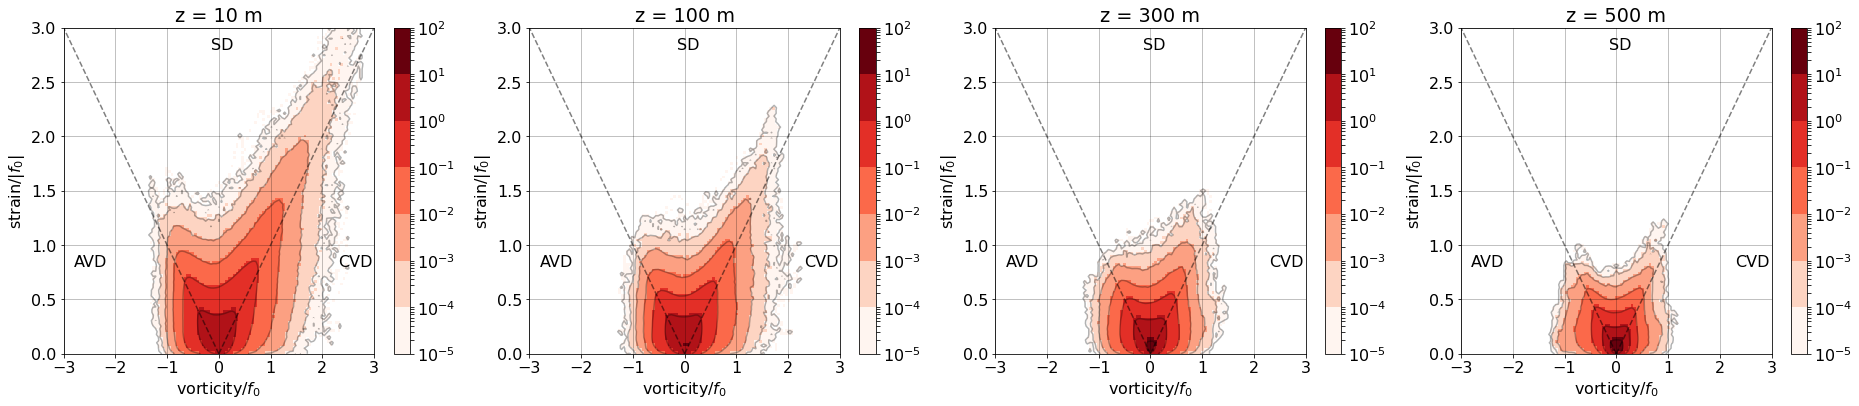

In [16]:
fig, ax = plt.subplots(figsize=(32,6))

ax = plt.subplot(141)
Jpdf_10m.plot(x='zeta_single_bin', y='strain_single_bin',vmin=1e-5,vmax=1e2,norm=cols.SymLogNorm(1e-5), cmap ='Reds',
          levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], extend='neither')
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N_winter.isel(depth=0).mean(dim='time').T), 
            levels=[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2], colors='k', alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.5)
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')
ax.set_xlim(-3,3)
ax.set_ylim(0,3)
plt.text(-0.15,2.8,'SD')
plt.text(2.3,.8,'CVD')
plt.text(-2.8,.8,'AVD')
plt.rc('grid', color='black', alpha=.3)
plt.grid()
ax.set_title('z = 10 m')

ax = plt.subplot(142)
Jpdf_100m.plot(x='zeta_single_bin', y='strain_single_bin',vmin=1e-5,vmax=1e2,norm=cols.SymLogNorm(1e-5), cmap ='Reds',
          levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], extend='neither')
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N_winter.isel(depth=1).mean(dim='time').T), 
            levels=[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2], colors='k', alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.5)
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')
ax.set_xlim(-3,3)
ax.set_ylim(0,3)
plt.text(-0.15,2.8,'SD')
plt.text(2.3,.8,'CVD')
plt.text(-2.8,.8,'AVD')
plt.rc('grid', color='black', alpha=.3)
plt.grid()
ax.set_title('z = 100 m')

ax = plt.subplot(143)
Jpdf_300m.plot(x='zeta_single_bin', y='strain_single_bin',vmin=1e-5,vmax=1e2,norm=cols.SymLogNorm(1e-5), cmap ='Reds',
          levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], extend='neither')
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N_winter.isel(depth=2).mean(dim='time').T), 
            levels=[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2], colors='k', alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.5)
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')
ax.set_xlim(-3,3)
ax.set_ylim(0,3)
plt.text(-0.15,2.8,'SD')
plt.text(2.3,.8,'CVD')
plt.text(-2.8,.8,'AVD')
plt.rc('grid', color='black', alpha=.3)
plt.grid()
ax.set_title('z = 300 m')

ax = plt.subplot(144)
Jpdf_500m.plot(x='zeta_single_bin', y='strain_single_bin',vmin=1e-5,vmax=1e2,norm=cols.SymLogNorm(1e-5), cmap ='Reds',
          levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], extend='neither')
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N_winter.isel(depth=3).mean(dim='time').T), 
            levels=[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2], colors='k', alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.5)
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')
ax.set_xlim(-3,3)
ax.set_ylim(0,3)
plt.text(-0.15,2.8,'SD')
plt.text(2.3,.8,'CVD')
plt.text(-2.8,.8,'AVD')
plt.rc('grid', color='black', alpha=.3)
plt.grid()
ax.set_title('z = 500 m')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_4depths_winter.png')

In [17]:
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)
ndepth = [6, 21, 32, 39] #10m, 100m, 300m, 500m

N_summer = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

In [22]:
binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

Jpdf_10m = (1/(binbox01*girbNums01)*(N_summer.isel(depth=0).rename('')).mean(dim='time').T)
Jpdf_100m = (1/(binbox01*girbNums01)*(N_summer.isel(depth=1).rename('')).mean(dim='time').T)
Jpdf_300m = (1/(binbox01*girbNums01)*(N_summer.isel(depth=2).rename('')).mean(dim='time').T)
Jpdf_500m = (1/(binbox01*girbNums01)*(N_summer.isel(depth=3).rename('')).mean(dim='time').T)

Jpdf_10m = xr.where(Jpdf_10m<1e-5,np.nan,Jpdf_10m)
Jpdf_100m = xr.where(Jpdf_100m<1e-5,np.nan,Jpdf_100m)
Jpdf_300m = xr.where(Jpdf_300m<1e-5,np.nan,Jpdf_300m)
Jpdf_500m = xr.where(Jpdf_500m<1e-5,np.nan,Jpdf_500m)

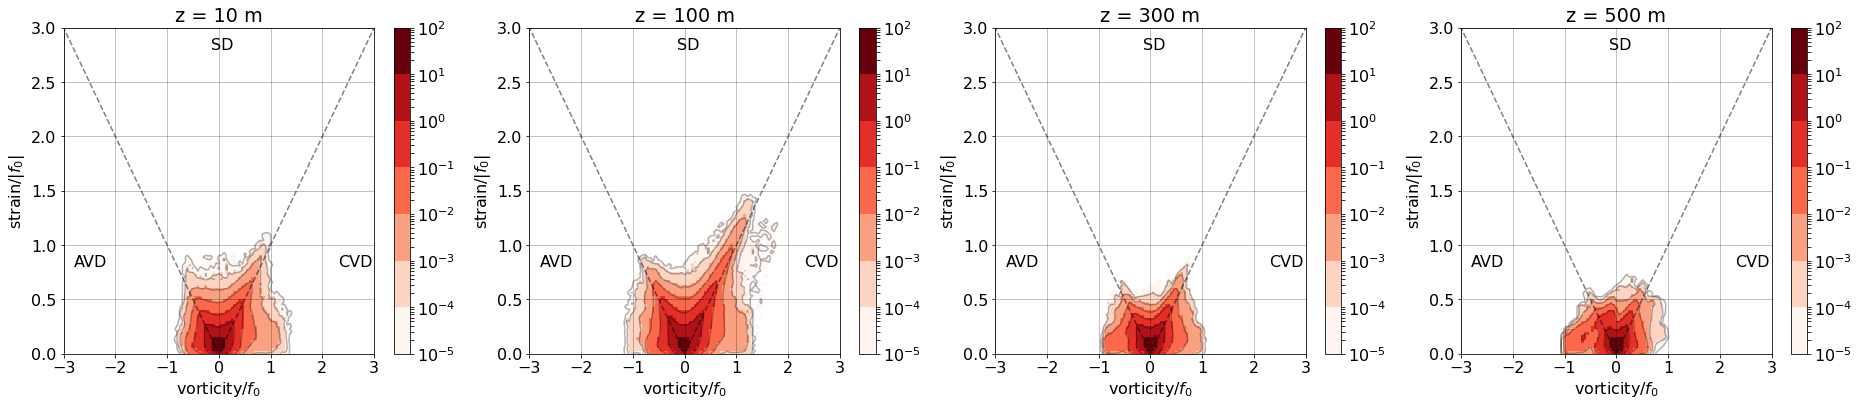

In [23]:
fig, ax = plt.subplots(figsize=(32,6))

ax = plt.subplot(141)
Jpdf_10m.plot(x='zeta_single_bin', y='strain_single_bin',vmin=1e-5,vmax=1e2,norm=cols.SymLogNorm(1e-5), cmap ='Reds',
          levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], extend='neither')
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N_summer.isel(depth=0).mean(dim='time').T), 
            levels=[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2], colors='k', alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.5)
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')
ax.set_xlim(-3,3)
ax.set_ylim(0,3)
plt.text(-0.15,2.8,'SD')
plt.text(2.3,.8,'CVD')
plt.text(-2.8,.8,'AVD')
plt.rc('grid', color='black', alpha=.3)
plt.grid()
ax.set_title('z = 10 m')

ax = plt.subplot(142)
Jpdf_100m.plot(x='zeta_single_bin', y='strain_single_bin',vmin=1e-5,vmax=1e2,norm=cols.SymLogNorm(1e-5), cmap ='Reds',
          levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], extend='neither')
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N_summer.isel(depth=1).mean(dim='time').T), 
            levels=[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2], colors='k', alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.5)
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')
ax.set_xlim(-3,3)
ax.set_ylim(0,3)
plt.text(-0.15,2.8,'SD')
plt.text(2.3,.8,'CVD')
plt.text(-2.8,.8,'AVD')
plt.rc('grid', color='black', alpha=.3)
plt.grid()
ax.set_title('z = 100 m')

ax = plt.subplot(143)
Jpdf_300m.plot(x='zeta_single_bin', y='strain_single_bin',vmin=1e-5,vmax=1e2,norm=cols.SymLogNorm(1e-5), cmap ='Reds',
          levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], extend='neither')
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N_summer.isel(depth=2).mean(dim='time').T), 
            levels=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2], colors='k', alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.5)
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')
ax.set_xlim(-3,3)
ax.set_ylim(0,3)
plt.text(-0.15,2.8,'SD')
plt.text(2.3,.8,'CVD')
plt.text(-2.8,.8,'AVD')
plt.rc('grid', color='black', alpha=.3)
plt.grid()
ax.set_title('z = 300 m')

ax = plt.subplot(144)
Jpdf_500m.plot(x='zeta_single_bin', y='strain_single_bin',vmin=1e-5,vmax=1e2,norm=cols.SymLogNorm(1e-5), cmap ='Reds',
          levels = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2], extend='neither')
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N_summer.isel(depth=3).mean(dim='time').T), 
            levels=[1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2], colors='k', alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.5)
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')
ax.set_xlim(-3,3)
ax.set_ylim(0,3)
plt.text(-0.15,2.8,'SD')
plt.text(2.3,.8,'CVD')
plt.text(-2.8,.8,'AVD')
plt.rc('grid', color='black', alpha=.3)
plt.grid()
ax.set_title('z = 500 m')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_4depths_summer.png')

_________
# 4.1 $w$ on vorticity-strain space (winter)

In [24]:
ndepth = [6, 21, 32, 39] #10m, 50m, 300m, 500m

vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.W_low_filter.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.746581.datarmor0/ipykernel_4351/4173240401.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/4173240401.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/4173240401.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either 

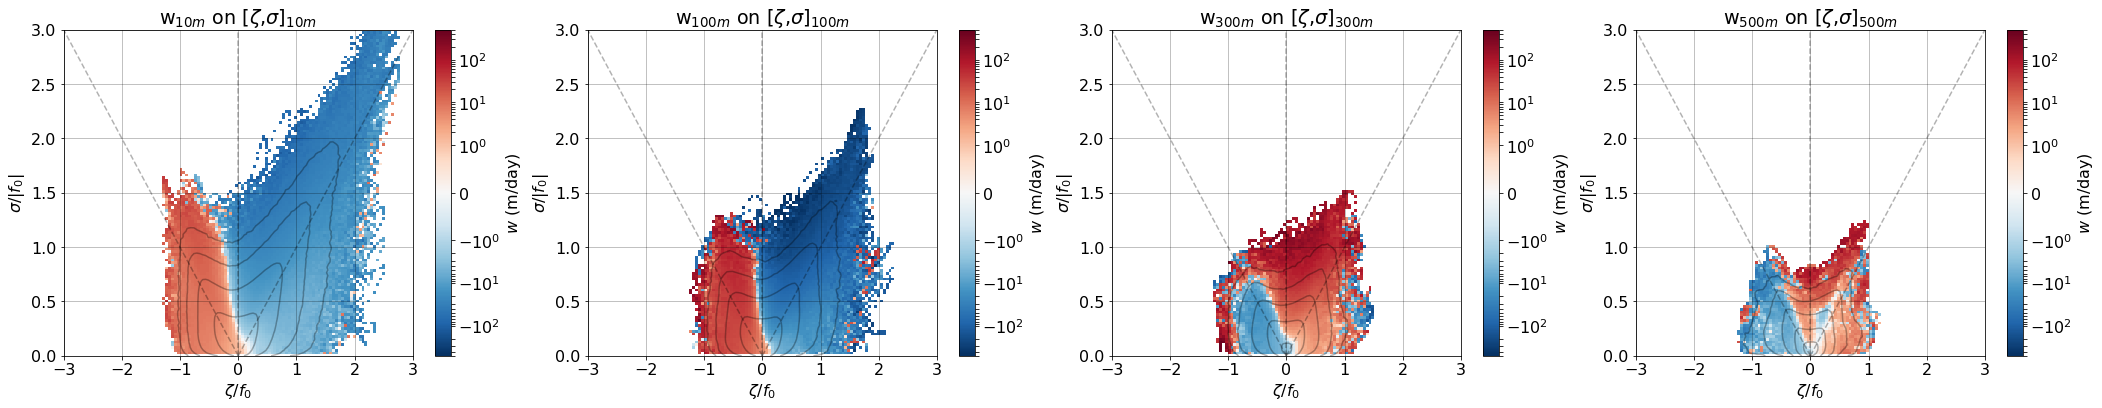

In [25]:
# w
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = (86400*(E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(36,6))

ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=5e2,vmin=-5e2,norm=cols.SymLogNorm(1e0), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w$ (m/day)')
ax.set_title('w$_{10m}$ on [$\zeta$,$\sigma$]$_{10m}$')


ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=5e2,vmin=-5e2,norm=cols.SymLogNorm(1e0), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w$ (m/day)')
ax.set_title('w$_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=5e2,vmin=-5e2,norm=cols.SymLogNorm(1e0), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w$ (m/day)')
ax.set_title('w$_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=3), 
             vmax=5e2,vmin=-5e2,norm=cols.SymLogNorm(1e0), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w$ (m/day)')
ax.set_title('w$_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_w_4depths_winter.png')

_________
# 4.2 $w$ on vorticity-strain space (summer)

In [26]:
ndepth = [6, 21, 32, 39] #10m, 100m, 300m, 500m

vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.W_low_filter.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.746581.datarmor0/ipykernel_4351/2038167938.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/2038167938.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/2038167938.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either 

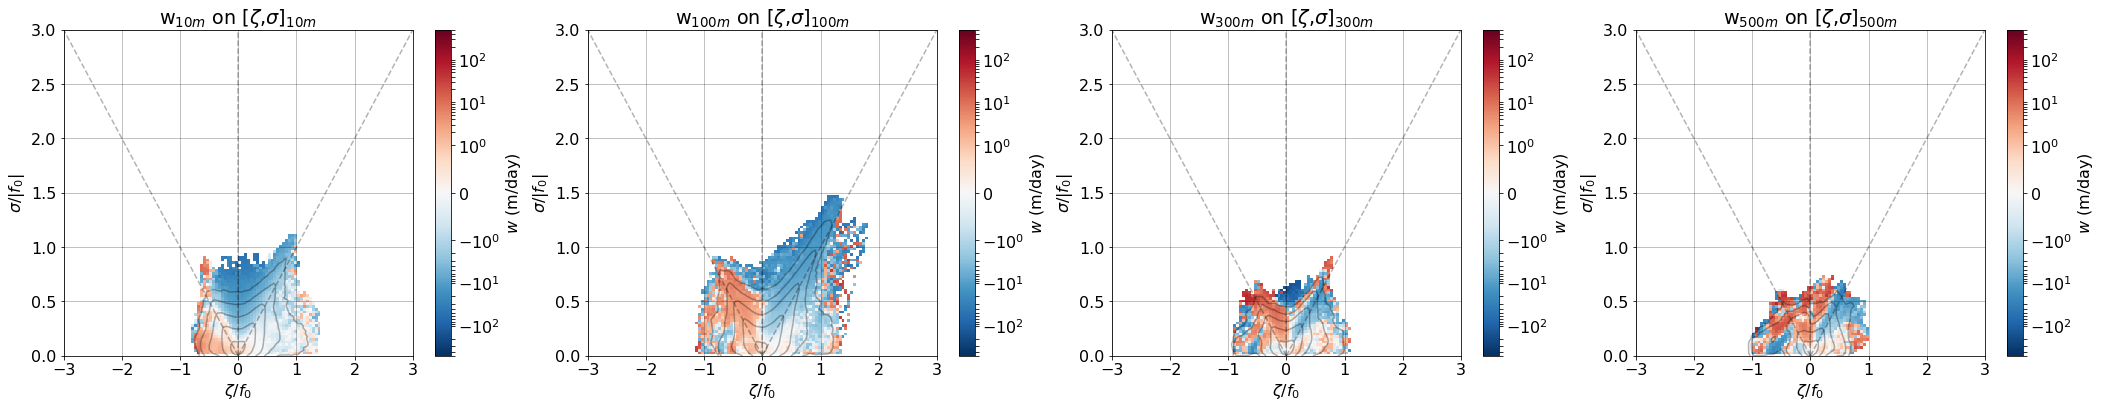

In [30]:
# w
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = (86400*(E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(36,6))

ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=5e2,vmin=-5e2,norm=cols.SymLogNorm(1e0), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w$ (m/day)')
ax.set_title('w$_{10m}$ on [$\zeta$,$\sigma$]$_{10m}$')


ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=5e2,vmin=-5e2,norm=cols.SymLogNorm(1e0), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w$ (m/day)')
ax.set_title('w$_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=5e2,vmin=-5e2,norm=cols.SymLogNorm(1e0), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w$ (m/day)')
ax.set_title('w$_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=3), 
             vmax=5e2,vmin=-5e2,norm=cols.SymLogNorm(1e0), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w$ (m/day)')
ax.set_title('w$_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_w_4depths_summer.png')

_________
# 4.2 $w'b'$ on vorticity-strain space (winter)

In [42]:
ndepth = [6, 21, 32, 39] #10m, 100m, 300m, 500m
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.wb_spatial_prime_filter.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2011-12-01','2012-03-01')).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.746581.datarmor0/ipykernel_4351/182337387.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/182337387.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/182337387.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either s

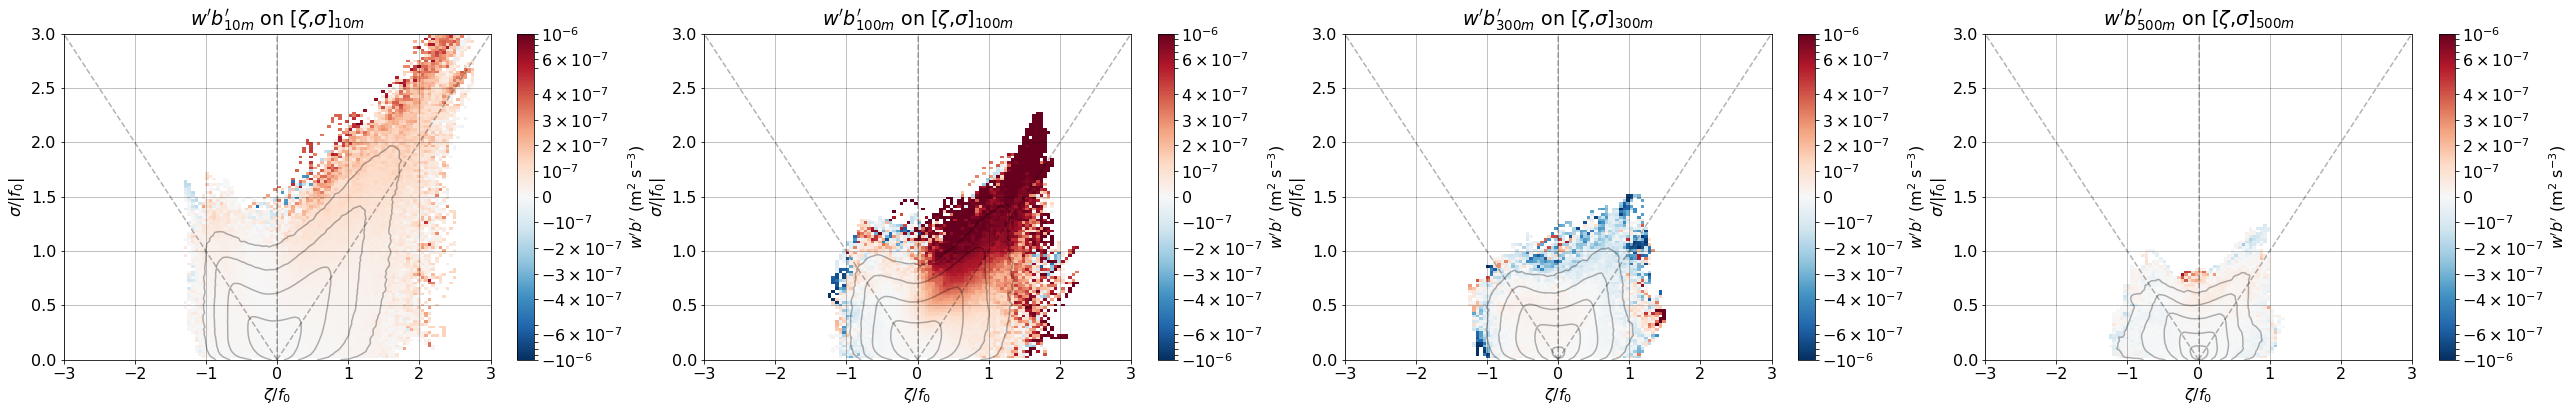

In [43]:
# w'b'
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
wb = ((E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(44,6))

ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{10m}$ on [$\zeta$,$\sigma$]$_{10m}$')


ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=1), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=2), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=3), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_wb_4depths_winter.png')

/dev/shm/pbs.746581.datarmor0/ipykernel_4351/207595293.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/207595293.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/207595293.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either s

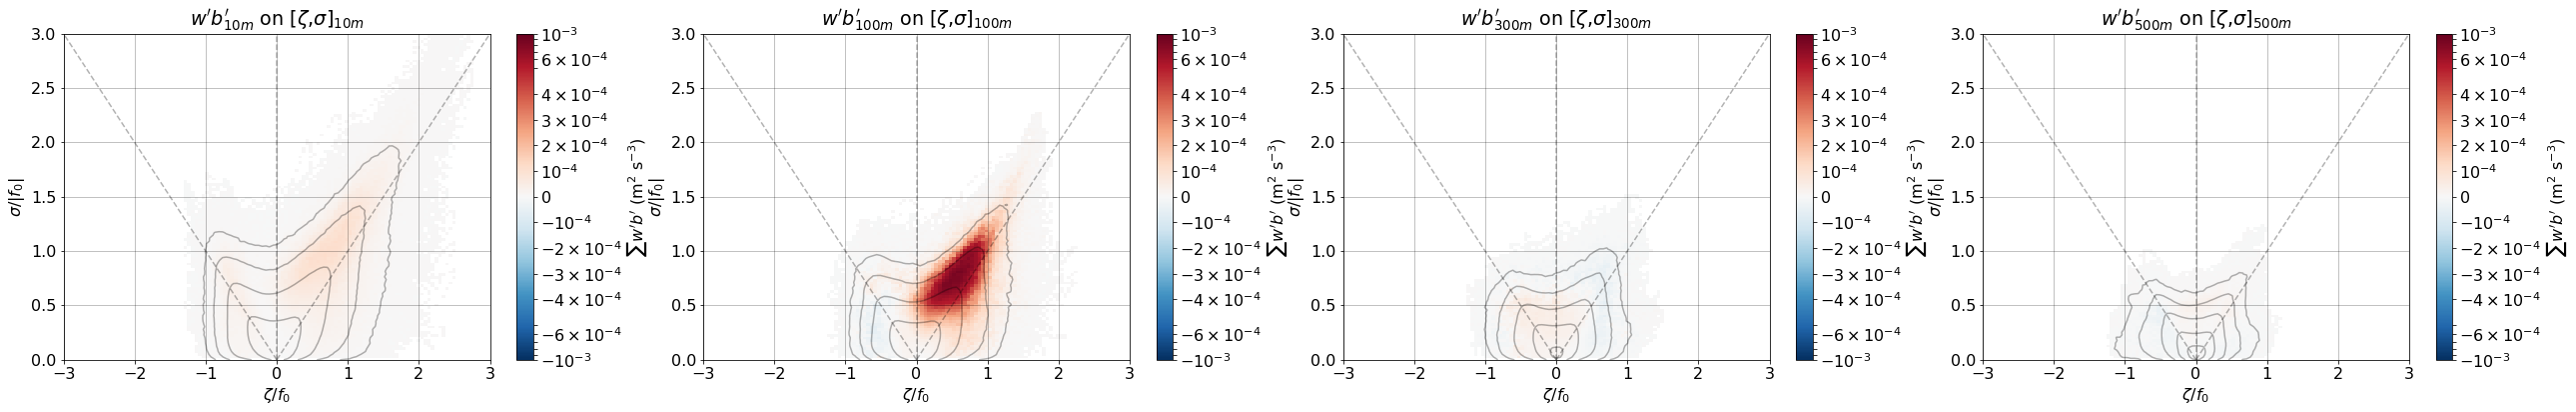

In [44]:
# w‘b'
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
wb = ((E/N).sum(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(44,6))

ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{10m}$ on [$\zeta$,$\sigma$]$_{10m}$')


ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=1), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=2), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=3), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_cum_wb_4depths_winter.png')

______
# Vertical buoyancy flux （$w^\prime b^\prime$）
# Summer


In [47]:
ndepth = [6, 21, 32, 39] #10m, 100m, 300m, 500m
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.wb_spatial_prime_filter.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).sel(time=slice('2012-06-01','2012-09-01')).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.746581.datarmor0/ipykernel_4351/4233993664.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/4233993664.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/4233993664.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eithe

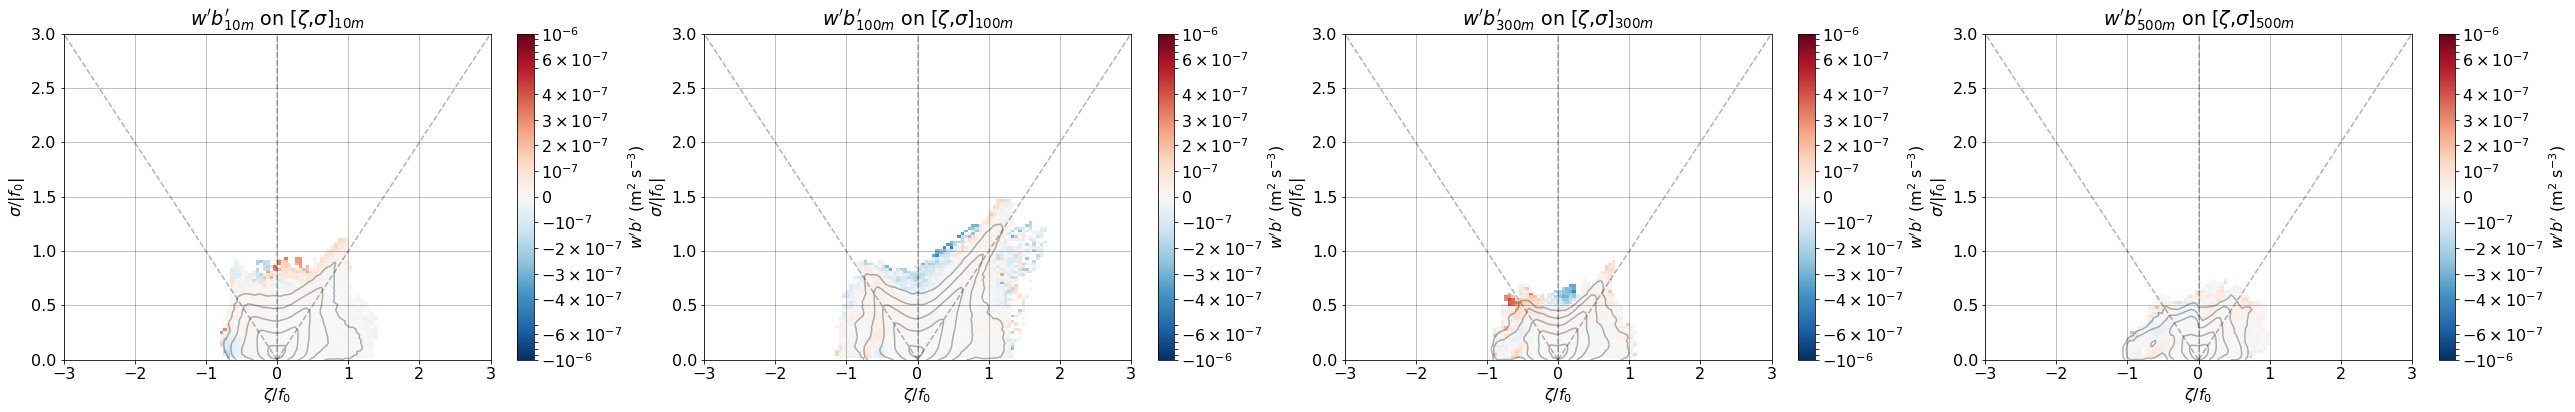

In [48]:
# w'b'
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
wb = ((E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(44,6))

ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{10m}$ on [$\zeta$,$\sigma$]$_{10m}$')


ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=1), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=2), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=3), 
             vmax=1e-6,vmin=-1e-6,norm=cols.SymLogNorm(5e-7), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_wb_4depths_summer.png')

/dev/shm/pbs.746581.datarmor0/ipykernel_4351/3809888807.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/3809888807.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0),
/dev/shm/pbs.746581.datarmor0/ipykernel_4351/3809888807.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eithe

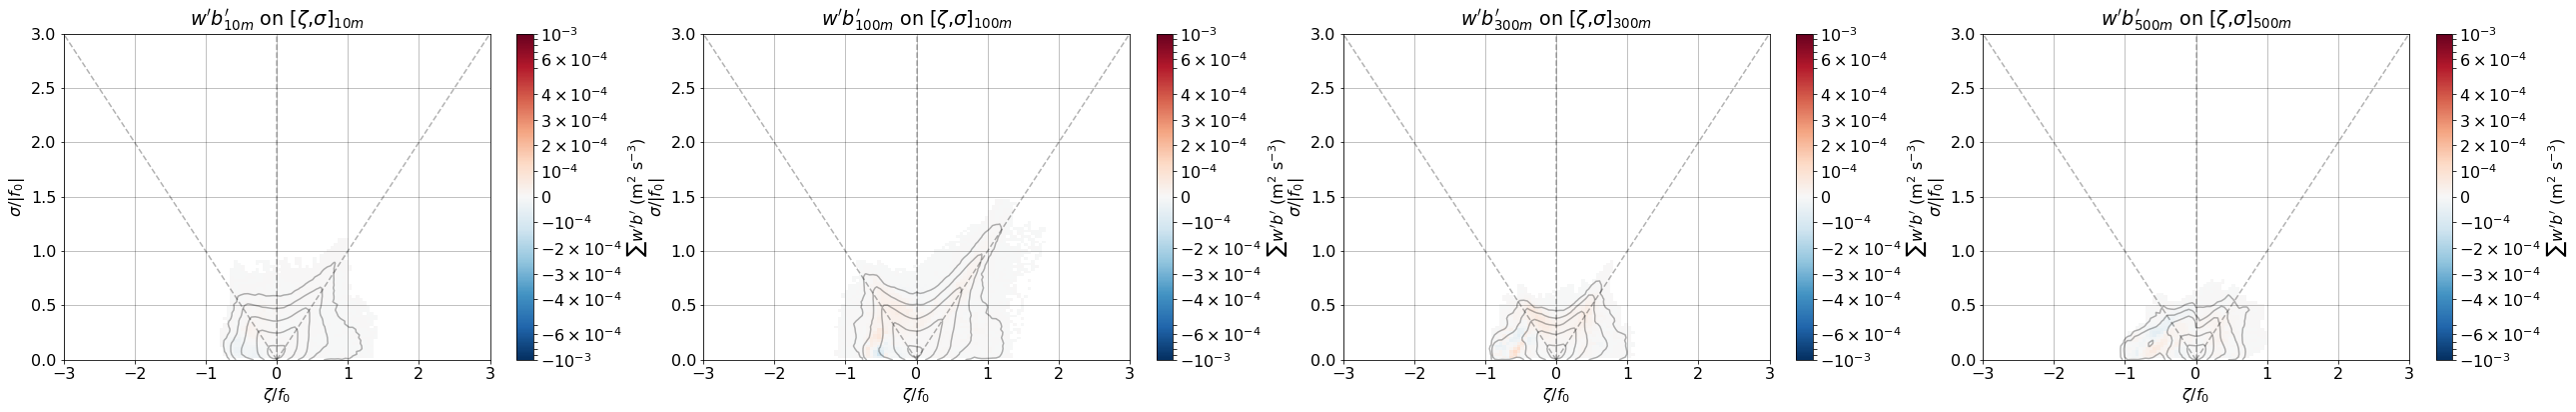

In [49]:
# w‘b'
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
wb = ((E/N).sum(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(44,6))

ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=0), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{10m}$ on [$\zeta$,$\sigma$]$_{10m}$')


ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=1), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=2), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{300m}$ on [$\zeta$,$\sigma$]$_{300m}$')


ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, wb.isel(depth=3), 
             vmax=1e-3,vmin=-1e-3,norm=cols.SymLogNorm(5e-4), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=3).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum w^\prime b^\prime$ (m$^2$ s$^{-3}$)')
ax.set_title('$w^\prime b^\prime_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_cum_wb_4depths_summer.png')

In [51]:
cluster.close()